# Estimating Spectra

trying different estimators for spectra

In [4]:
import os
import sys
if './df_analysis' not in sys.path:
    sys.path.append('./df_analysis/')
import scipy as sp
import numpy as np
import mtspec
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2
%aimport - numpy - scipy - matplotlib.pyplot

In [5]:
import statsmodels.tsa as tsa
from statsmodels.tsa.arima_process import ArmaProcess
from bb_analysis_timeseries import AnalyzeTimeSeries as ATS

## Why is the periodogram is a bad estimator?
1. not robust: more data points do not lead to a decrease in the estimate variance
1. spectral leakage: intensitiesare contaminated with variance from far aways frequencies. Can be solved with tapers.

I will use three time series with known spectra to illustrate the problems and compare different spectral estimators.
1. `A` white noise time series: theoretical power spectrum $\Gamma(\omega) = \mathrm{var}(A)$
1. `B` AR(2) process ($\alpha_1=0.3, \alpha_2=0.3$)
1. `C` AR(2) process ($\alpha_1=0.9, \alpha_2=-0.8$)



Ghil et al. (2000): 
> For instrumental climate records, with a typical length of a few hundred points, the choice p ⫽ 2 and K ⫽ 3 offers a good compromise between the required frequency resolution for resolving distinct cli- mate signals (e.g., ENSO and decadal-scale variability) and the benefit of multiple spectral degrees of freedom, i.e., of reduced variance [e.g., Mann and Park, 1993].

## Autoregressive processes

The order $p$ autoregressive process is defined as
$$ X_t = \sum_{p=1}^{p} \phi_p X_{t-p} + \sigma_\epsilon^2 \epsilon_t + c$$
where $\epsilon_t$ is a white noise process.

The mean of an AR(1) process is
$$\mu_X = \frac{c}{1-\phi_1}$$
while the variance is 
$$\mathrm{var}(X(t)) = \frac{\sigma_\epsilon^2}{1-\phi_1^2}$$

Yule-Walker method for estimating the autocorrelation and noise amplitude for an AR(1) process:

\begin{align}
    \hat{\phi}_1 & = r_1 \\
    \hat{\sigma}_\epsilon^2 & = T^{-1} \sum_{t=1}^T (X'_t - \hat{\phi}_1 X'_t)^2
\end{align}
where $X'_t = X_t - \bar{X}$

The theoretical power spectrum of an AR(2) process is (p. 224 von Storch and Zwiers)
$$\Gamma(\omega) = \frac{\sigma_\epsilon^2}{1 + \alpha_1^2 + \alpha_2^2 - 2\alpha_1 (1 - \alpha_2) \cos(2 \pi \omega) + 2 \alpha_2 \cos(4 \pi \omega)}$$


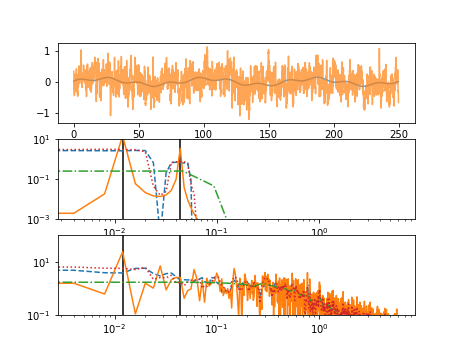

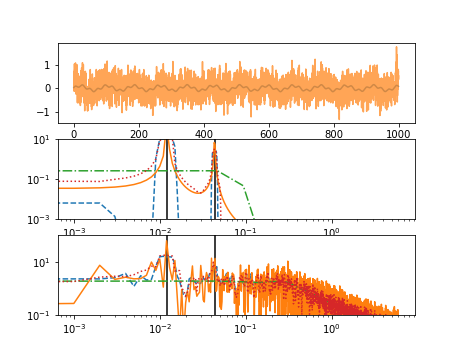

In [8]:

np.random.seed(1)
for N in [250,1000]:
    a_ = np.array([.1*np.sin(2*np.pi/82*t) + .05*np.sin(2*np.pi/23*t+.5) for t in np.arange(12*N)/12])
    b_ = a_ + ArmaProcess(np.array([1, -.8]), np.array([1])).generate_sample(scale=.2, nsample=12*N)# np.random.rand((12*N))
    b_ -= np.mean(b_)
    # data -= np.mean(data)
    a = xr.DataArray(data=a_, dims='time', coords={'time':np.arange(12*N)/12})
    b = xr.DataArray(data=b_, dims='time', coords={'time':np.arange(12*N)/12})
    # a -= xr_lintrend(a)
    
    f, ax = plt.subplots(3,1, figsize=(6.4,5))
    
    ax[0].plot(a.time, a, alpha=.7)
    ax[0].plot(b.time, b, alpha=.7)
    
    for i, da in enumerate([a,b]):
        ax[i+1].axvline(1/82, c='k')
        ax[i+1].axvline(1/23, c='k')
        
        freq, spec = ATS(da).mtspectrum()
        ax[i+1].plot(freq*12, spec, ls='--', c='C0')

        freq, spec = ATS(da).periodogram()
        ax[i+1].plot(freq*12, spec, ls='-', c='C1')

        freq, spec = ATS(da).Welch()
        ax[i+1].plot(freq*12, spec, ls='-.', c='C2')

        freq, spec = ATS(da).mtspectrum(tb=2, nt=5)
        ax[i+1].plot(freq*12, spec, ls=':', c='C3')

        ax[i+1].loglog()
    ax[1].set_ylim(1e-3,1e1)   
    ax[2].set_ylim(1e-1,1e2)

In [5]:
def periodogram(ts, d=1.):
    """ naive absolute squared Fourier components 
    
    input:
    ts .. time series
    d  .. sampling period
    """
    freq = np.fft.rfftfreq(len(ts))
    Pxx = 2*np.abs(np.fft.rfft(ts))**2/len(ts)
    return freq, Pxx

def Welch(ts, d=1, window='hann'):
    """ Welch spectrum """
    return sp.signal.welch(ts, window=window)

def mtspectrum(ts, d=1., tb=4, nt=4):
    """ multi-taper spectrum 
    
    input:
    ts .. time series
    d  .. sampling period
    tb .. time bounds (bandwidth)
    nt .. number of tapers
    """
    spec, freq, jackknife, _, _ = mtspec.mtspec(
                data=ts, delta=d, time_bandwidth=tb,
                number_of_tapers=nt, statistics=True)
    return freq, spec

In [8]:
def AR2_process(a1, a2, N):
    """ generates AR(2) time series of length N """
    return ArmaProcess(np.array([1, -a1, -a2]), np.array([1])).generate_sample(nsample=N)

def AR2_spectrum(sz, a1, a2, omega):
    """ theoretical AR(2) spectrum 
    
    input:
    sz     .. standard deviation
    a1, a2 .. AR(2) coefficients
    omega  .. frequency at which to evaluate expression
    """
    # multiplied here by an extra factor of 2, so that we can integrate over [0,0.5] and not over [-0.5.0.5]
    return 2*sz**2/(1+a1**2+a2**2-2*(a1*(1-a2)*np.cos(2*np.pi*omega)+a2*np.cos(4*np.pi*omega)))

N = 2000
A = np.random.rand((N))-.5
A /= np.std(A)
b = 0.3
B_ = AR2_process(b, b, N)
B = B_ + 10*np.sin(2*np.pi*.3162*np.arange((N))+.5763)
# B /= np.std(B)
c1, c2 = .9, -.8
C = AR2_process(c1, c2, N)

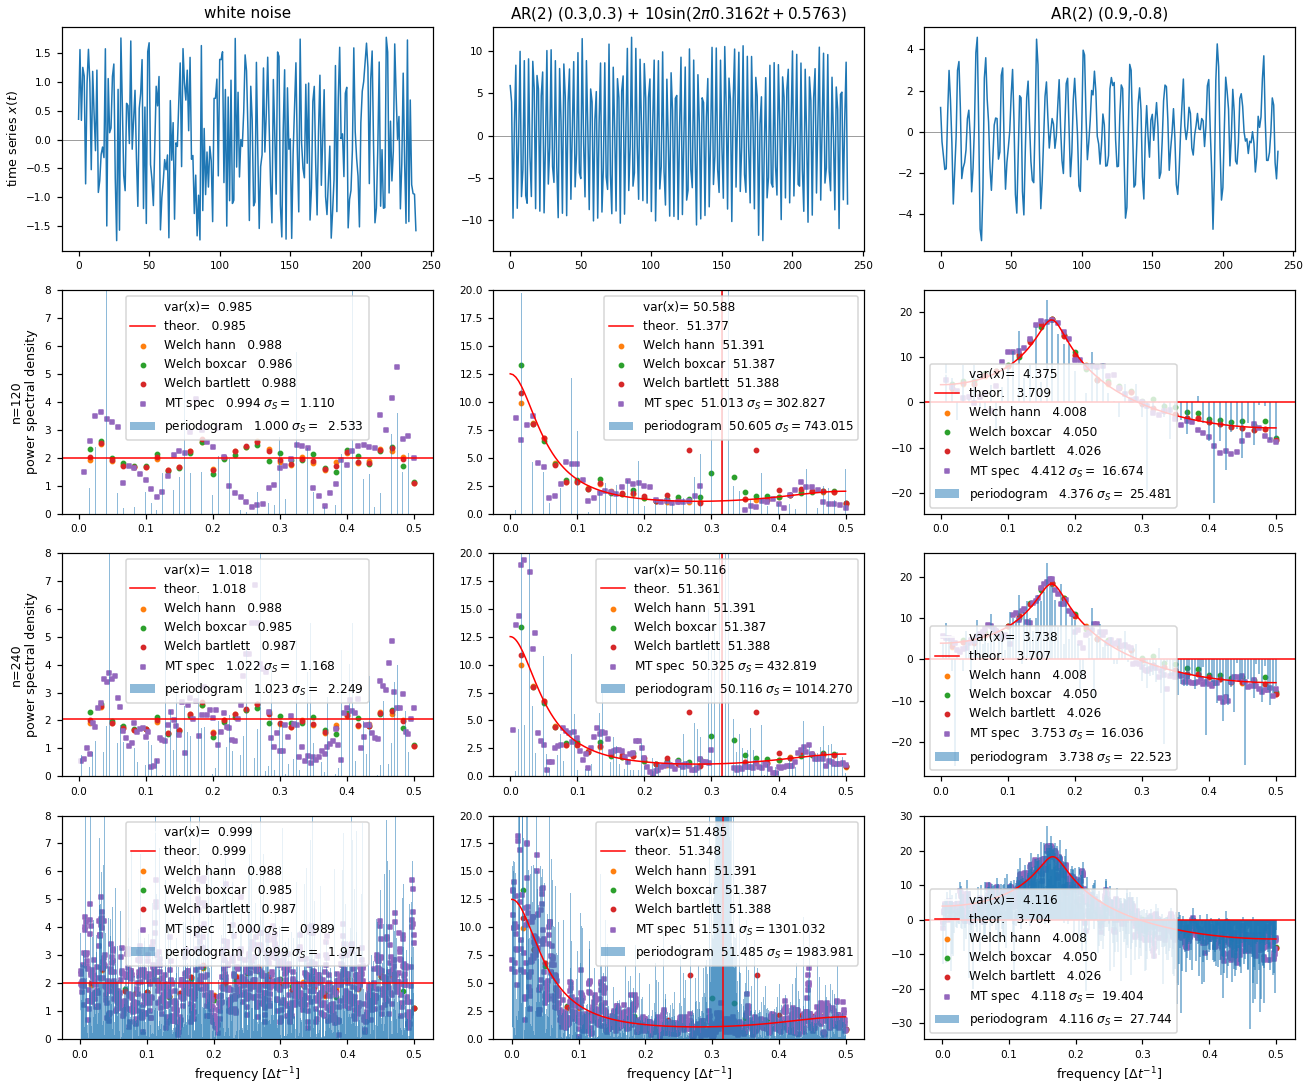

In [9]:
f, ax = plt.subplots(4,3,figsize=(12,10), constrained_layout=True)
for i, ts in enumerate([A,B,C]):
    ax[0,i].axhline(0, c='grey', lw=.5)
    ax[0,i].plot(np.arange(240), ts[:240])
    
    for j, ts_ in enumerate([ts[:120], ts[:240], ts]):
        ts_ -= np.mean(ts_)
        ax[j+1,i].plot([0,0],[0,1], c='w', label=f'var(x)={np.var(ts_):7.3f}')
        freq = np.linspace(0,.5,len(ts_))
        if i==0:  
            ax[j+1,i].axhline(2*np.var(ts_), c='r', label=f'theor. {np.var(ts_):7.3f}')
            # multiplied here by an extra factor of 2, so that we can integrate over [0,0.5] and not over [-0.5.0.5]
        if i==1:
            spec = AR2_spectrum(sz=1, a1=b , a2=b , omega=freq)
            ax[j+1,i].plot(freq, spec, c='r', label=f'theor. {np.sum((freq[1]-freq[0])*spec)+50:7.3f}')
            # variance of sin with amplitude A: A^2/2
            ax[j+1,i].axvline(.3162, c='r')

        if i==2:
            spec = AR2_spectrum(sz=1 , a1=c1, a2=c2, omega=freq)
            ax[j+1,i].plot(freq, 10*np.log10(spec), c='r', label=f'theor. {np.sum((freq[1]-freq[0])*spec):7.3f}')
            ax[j+1,i].axhline(0, c='r')
            
        freq, Pxx = periodogram(ts_)
        label = f'periodogram {np.sum((freq[1]-freq[0])*Pxx):7.3f} $\sigma_S=${np.std(Pxx):7.3f}'
        if i<2:  ax[j+1,i].bar(freq[1:], Pxx[1:]             , width=.001, alpha=.5, label=label)
        else  :  ax[j+1,i].bar(freq[1:], 10*np.log10(Pxx[1:]), width=.003, alpha=.5, label=label)
        
        for window in ['hann', 'boxcar', 'bartlett']:
            f, Pxx = sp.signal.welch(ts, window=window, nperseg=60)#, average='median')
            label = f'Welch {window} {np.sum((f[1]-f[0])*Pxx):7.3f}'
            if i<2:  ax[j+1,i].scatter(f[1:], Pxx[1:]             , s=8, label=label)
            else  :  ax[j+1,i].scatter(f[1:], 10*np.log10(Pxx[1:]), s=8, label=label)        
        
        freq, Pxx = mtspectrum(ts_)
        label= f'MT spec {np.sum((freq[1]-freq[0])*Pxx):7.3f} $\sigma_S=${np.std(Pxx):7.3f}'
        if i<2:  ax[j+1,i].scatter(freq[1:], Pxx[1:]             , s=10, marker='s', label=label)
        else  :  ax[j+1,i].scatter(freq[1:], 10*np.log10(Pxx[1:]), s=10, marker='s', label=label)
        
        if i==0: ax[j+1,i].set_ylim((0,8))
        if i==1: ax[j+1,i].set_ylim((0,20))
        ax[j+1,i].legend(fontsize=8)
        
for i in range(3):
    ax[0,i].set_title(['white noise', r'AR(2) (0.3,0.3) + $10 \sin(2 \pi 0.3162 t + 0.5763)$','AR(2) (0.9,-0.8)'][i])
    ax[i,0].set_ylabel([r'time series $x(t)$', 'n=120\npower spectral density','n=240\npower spectral density'][i])
    ax[-1,i].set_xlabel(r'frequency [$\Delta t^{-1}$]')

## index time series

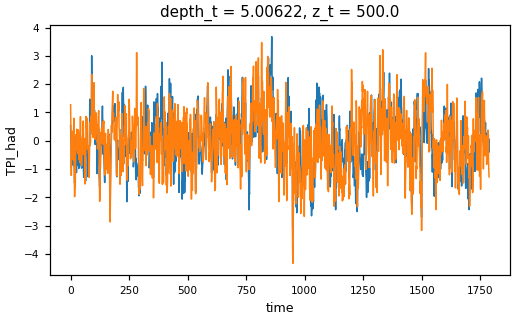

In [126]:
plt.plot(xr.open_dataset(f'{path_samoc}/SST/PMV_EOF_20N_had.nc').pcs.isel(mode=0))
(ds['TPI_had']/ds['TPI_had'].std()).plot()

In [8]:
# das = []
# for idx in ['AMO', 'TPI', 'SOM']:
#     for run in ['had', 'ctrl', 'lpd']:
#         if run=='ctrl':   ts, Nt = '_51_301', 250*12
#         elif run=='lpd':  ts, Nt = '_154_404', 250*12
#         elif run=='had':  ts, Nt = '', 149*12
#         fn = f'{path_samoc}/SST/{idx}_ds_dt_raw_{run}{ts}.nc'
#         print(os.path.exists(fn))
#         da = xr.open_dataarray(fn, decode_times=False).assign_coords(time=np.arange(Nt))
#         da.name = f'{idx}_{run}'
#         das.append(da)

In [9]:
ds = xr.open_dataset(f'{path_results}/all_timeseries.nc')

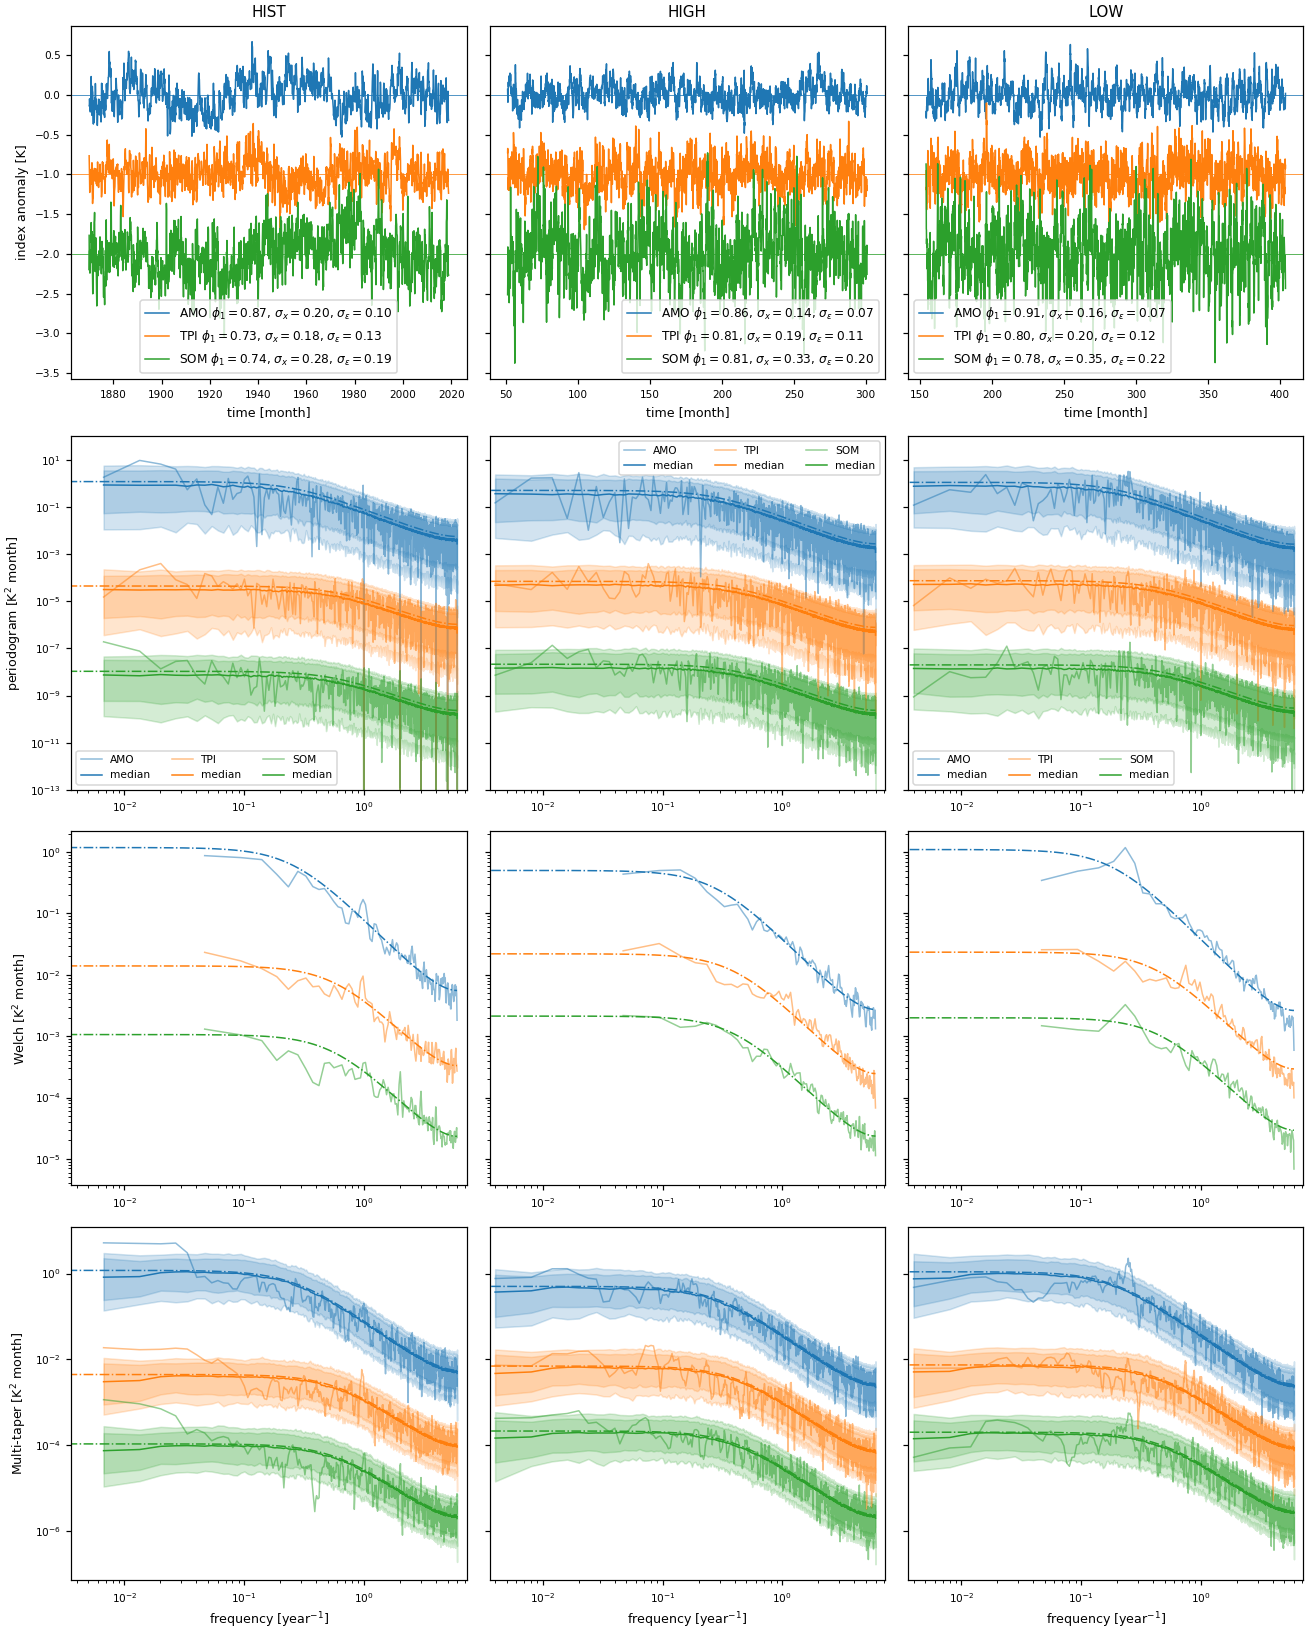

In [116]:
fig, ax = plt.subplots(4,3,figsize=(12,15),constrained_layout=True, sharey='row')
for i, idx in enumerate(['AMO', 'TPI', 'SOM']):
    for j, run in enumerate(['had', 'ctrl', 'lpd']):
        c = f'C{i}'
        key = f'{idx}_{run}'
        x = ds[key].dropna(dim='time')
        f = np.linspace(0,0.5,len(x))
        std_ = ds[key].std().values
        AM = ARMA(endog=x.values, order=(1,0)).fit()
        ac, std = AM.arparams[0], np.sqrt(AM.sigma2)
        ax[0,j].plot(ds.time/12+[1870,51,154][j], ds[key]-i, label=fr'{idx} $\phi_1=${ac:.2f}, $\sigma_x=${std_:.2f}, $\sigma_\epsilon=${std:.2f}', c=c)
        ax[0,j].axhline(-i, c=c, lw=.5)
        
        for k in range(3):  ax[k+1,j].plot(f[1:]*12, AR2_spectrum(sz=std, a1=ac, a2=0, omega=f)[1:]*10**(-[4,1.5,2][k]*i), c=c, ls='-.')
        
        f, Pxx = periodogram(x)
        ax[1,j].plot(f[1:]*12, Pxx[1:]*10**(-4*i), c=c, alpha=.5, label=fr'{idx}')#' $\rho_1$={ac:.3f}')
        mc = mc_ar1_spectrum(x.values, spectrum=periodogram)
        ax[1,j].plot(mc['freq'][1:]*12, mc['median'][1:]*10**(-4*i), c=c, ls='-' , label='median')
        ax[1,j].fill_between(mc['freq'][1:]*12, mc['1'][1:]*10**(-4*i), mc['99'][1:]*10**(-4*i), color=c, alpha=0.2)
        ax[1,j].fill_between(mc['freq'][1:]*12, mc['5'][1:]*10**(-4*i), mc['95'][1:]*10**(-4*i), color=c, alpha=0.2)
        
        f, Pxx = Welch(x)
        ax[2,j].plot(f[1:]*12, Pxx[1:]*10**(-1.5*i), c=c, alpha=.5, label=fr'{idx} $\rho_1$={ac:.3f}')
        
        f, Pxx = mtspectrum(x)
        ax[3,j].plot(f[1:]*12, Pxx[1:]*10**(-2*i), c=c, alpha=.5, label=fr'{idx} $\rho_1$={ac:.3f}')
        mc = mc_ar1_spectrum(x.values, spectrum=mtspectrum)
        ax[3,j].plot(mc['freq'][1:]*12, mc['median'][1:]*10**(-2*i), c=c, ls='-' , label='median')
        ax[3,j].fill_between(mc['freq'][1:]*12, mc['1'][1:]*10**(-2*i), mc['99'][1:]*10**(-2*i), color=c, alpha=0.2)
        ax[3,j].fill_between(mc['freq'][1:]*12, mc['5'][1:]*10**(-2*i), mc['95'][1:]*10**(-2*i), color=c, alpha=0.2)
        
for i in range(3):
    ax[0,i].set_title(['HIST', 'HIGH', 'LOW'][i])
    ax[0,i].set_xlabel(r'time [month]')
    ax[-1,i].set_xlabel(r'frequency [year$^{-1}$]')
    ax[1,i].set_ylim((1e-13, 1e2))
    ax[0,i].legend(fontsize=8)
    ax[1,i].legend(fontsize=7, ncol=3)
    for j in range(3):
        ax[j+1,i].set_xlim((12*3e-4, 12*6e-1))
        ax[j+1,i].set_xscale('log', basex=10)
        ax[j+1,i].set_yscale('log', basey=10)

for i in range(4):  ax[i,0].set_ylabel(['index anomaly [K]', r'periodogram [K$^2$ month]', r'Welch [K$^2$ month]', r'Multi-taper [K$^2$ month]'][i])
plt.savefig(f'{path_results}/spectra/indices, spectra')

## Fitting AR(1) spectra: theoretical vs. MC spectral estimates

In [69]:
from statsmodels.tsa.arima_model import ARMA

def mc_ar1_ARMA(phi, std, n, N=1000):
    """ Monte-Carlo AR(1) processes
    
    input:
    phi .. (estimated) lag-1 autocorrelation
    std .. (estimated) standard deviation of noise
    n   .. length of original time series
    N   .. number of MC simulations 
    """
    AR_object = ArmaProcess(np.array([1, -phi]), np.array([1]), nobs=n)
    mc = AR_object.generate_sample(nsample=(N,n), scale=std, axis=1, burnin=1000)
    return mc

def mc_ar1_spectrum(x, spectrum, N=1000, filter_type=None, filter_cutoff=None):
    """ calculates the Monte-Carlo spectrum and the 95% confidence interval
    
    input:
    x             .. time series
    spectrum      .. spectral density estimation function
    N             .. number of MC simulations
    filter_type   ..
    filter_cutoff ..
    
    output:
    mc_spectrum   .. 
    """
    AM = ARMA(endog=x, order=(1,0)).fit()
    phi, std = AM.arparams[0], np.sqrt(AM.sigma2)
    mc = mc_ar1_ARMA(phi=phi, std=std, n=len(x), N=N)
    mc_spectra = np.zeros((N, int(len(mc[0,:])/2)+1))
    for i in range(N):  freq, mc_spectra[i,:] = spectrum(mc[i,:])
    mc_spectrum = {}
    mc_spectrum['median'] = np.median(mc_spectra, axis=0)
    mc_spectrum['freq'] = freq
    for p in [1,2.5,5,95,97.5,99]:
        mc_spectrum[str(p)] = np.percentile(mc_spectra, p, axis=0)
    return mc_spectrum

## testing AR(1) spectral density estimates: theoretical vs. Monte-Carlo

(1000, 10000)
(1000, 10000)
0.013631980944455498 0.013633344278883342 0.012459030072119643 0.012732640860063253
(1000, 10000)
(1000, 10000)
0.333036713142338 0.333070020144353 0.3109311910472521 0.3109242323947637
(1000, 10000)
(1000, 10000)
1.0773410850981724 1.0774488299811698 1.008105157976871 1.0064239363984926


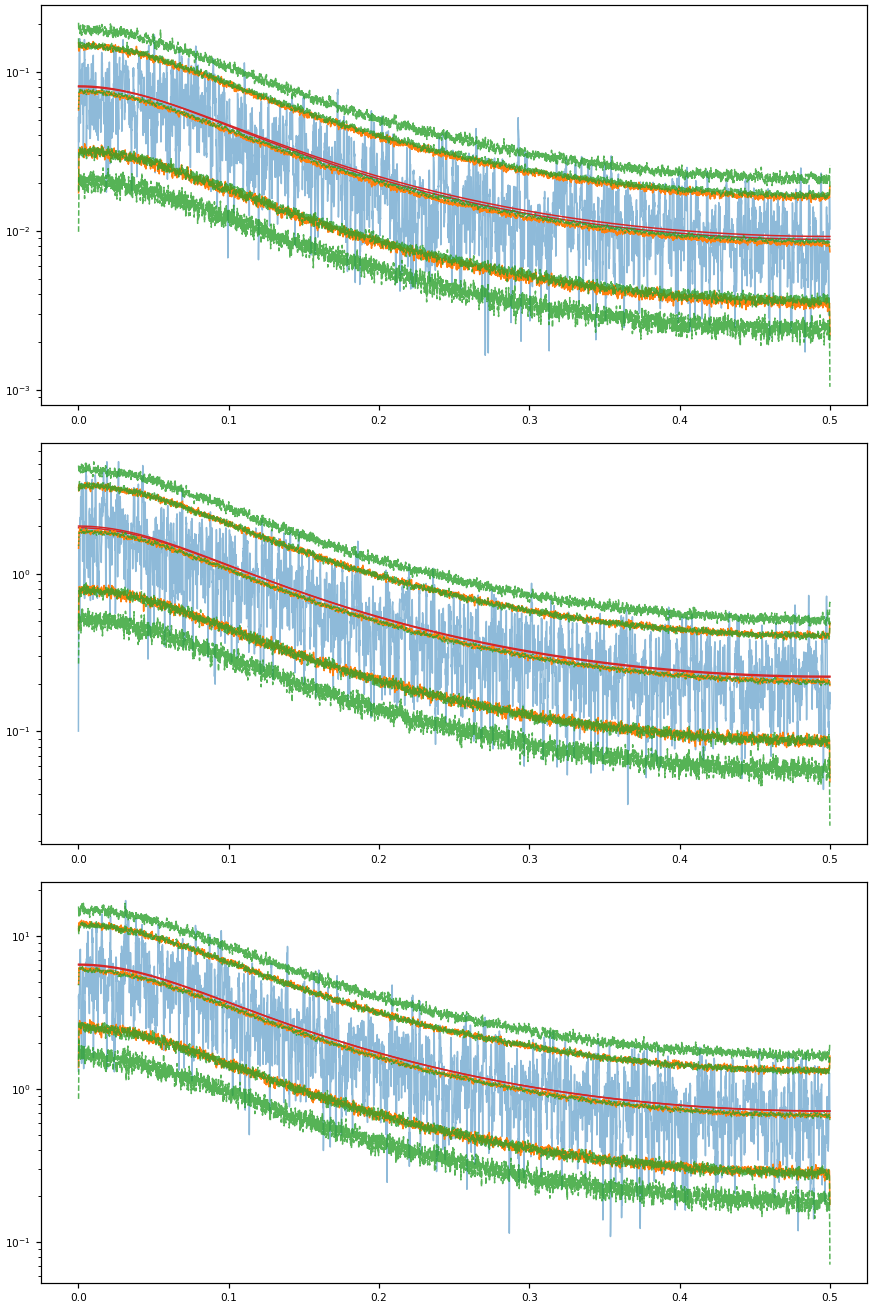

In [45]:
# long AR(1) processes and their MC spectra
f, ax = plt.subplots(3,1, figsize=(8,12))
for i, std in enumerate([.1, .5, .9]):
    n, phi = 10000, 0.5
    x = ArmaProcess(np.array([1, -phi]), np.array([1])).generate_sample(nsample=n, scale=std, burnin=1000)

    f, Pxx = mtspectrum(x)
    ax[i].plot(f, Pxx, alpha=.5)
    Pxx_th = AR2_spectrum(sz=std, a1=ac, a2=0, omega=f)
    ax[i].plot(f[1:], Pxx_th[1:], c='C3')

    mc_ = mc_ar1_spectrum(std=std, phi=phi, n=n, spectrum=mtspectrum)
    ax[i].plot(mc_[1,1:], mc_[0,1:], c='C1')
    ax[i].plot(mc_[1,1:], mc_[2,1:], c='C1')
    ax[i].plot(mc_[1,1:], mc_[3,1:], c='C1')

    AM = ARMA(endog=x, order=(1,0)).fit()
    ac, std = AM.arparams[0], np.sqrt(AM.sigma2)
    mc = mc_ar1_spectrum(std=std, phi=ac, n=len(x), spectrum=mtspectrum)
    ax[i].plot(mc[1,1:], mc[0,1:], c='C2', ls=':' , alpha=.8)
    ax[i].plot(mc[1,1:], mc[2,1:], c='C2', ls='--', alpha=.8)
    ax[i].plot(mc[1,1:], mc[3,1:], c='C2', ls='--', alpha=.8)
    ax[i].plot(mc[1,1:], mc[4,1:], c='C2', ls='--', alpha=.8)
    ax[i].plot(mc[1,1:], mc[5,1:], c='C2', ls='--', alpha=.8)

    ax[i].plot(f[1:], AR2_spectrum(sz=std, a1=ac, a2=0, omega=f)[1:], c='C3')

    ax[i].set_yscale('log', basey=10)

    print(f'{np.var(x):7.3f}, {np.sum((f[1]-f[0])*Pxx):7.3f}, {np.sum((f[1]-f[0])*Pxx_th):7.3f}, {np.sum((mc_[1,1]-mc_[1,0])*mc_[0,:]):7.3f}, {np.sum((mc[1,1]-mc[1,0])*mc[0,:]):7.3f}')

In [105]:
for n in [10, 100, 1000, 10000]:
    for phi in [.1,.5,.9]:
        for std in [.1,.5,.9]:
            x = ArmaProcess(np.array([1, -phi]), np.array([1])).generate_sample(nsample=n, scale=std, burnin=1000)
            # Yule Walker estimate 
            phi_YW = np.corrcoef(x[:-1], x[1:])[1,0]
            y = x-np.mean(x)
            std_YW = np.sqrt(np.sum((y[1:]-phi_YW*y[:-1])**2)/(len(y)-1))
            # max likelihood estimation of parameters
            AM = ARMA(endog=x, order=(1,0)).fit()
            phi_ML, std_ML = AM.arparams[0], np.sqrt(AM.sigma2)
            print(f'{n:5}: phi={phi:3.1f}, std={std:3.1f},   YW: {phi_YW:6.3f}, {std_YW:6.3f}, MLE: {phi_ML:6.3f}, {std_ML:6.3f}')


   10: phi=0.1, std=0.1,   YW: -0.278,  0.096, MLE: -0.256,  0.091
   10: phi=0.1, std=0.5,   YW:  0.214,  0.401, MLE:  0.196,  0.386
   10: phi=0.1, std=0.9,   YW:  0.014,  0.904, MLE:  0.024,  0.872
   10: phi=0.5, std=0.1,   YW:  0.238,  0.065, MLE:  0.259,  0.074
   10: phi=0.5, std=0.5,   YW: -0.578,  0.306, MLE: -0.540,  0.292
   10: phi=0.5, std=0.9,   YW:  0.435,  0.904, MLE:  0.447,  0.855
   10: phi=0.9, std=0.1,   YW:  0.500,  0.111, MLE:  0.576,  0.104
   10: phi=0.9, std=0.5,   YW:  0.809,  0.290, MLE:  0.792,  0.288
   10: phi=0.9, std=0.9,   YW:  0.522,  0.836, MLE:  0.542,  0.821
  100: phi=0.1, std=0.1,   YW:  0.031,  0.101, MLE:  0.031,  0.101
  100: phi=0.1, std=0.5,   YW:  0.119,  0.556, MLE:  0.122,  0.555
  100: phi=0.1, std=0.9,   YW:  0.031,  0.960, MLE:  0.031,  0.965
  100: phi=0.5, std=0.1,   YW:  0.499,  0.092, MLE:  0.495,  0.091
  100: phi=0.5, std=0.5,   YW:  0.541,  0.510, MLE:  0.537,  0.508
  100: phi=0.5, std=0.9,   YW:  0.522,  0.840, MLE:  0.532,  0

(1000, 1788)
(1000, 3000)
(1000, 3000)
(1000, 1788)
(1000, 3000)
(1000, 3000)
(1000, 1788)
(1000, 3000)
(1000, 3000)


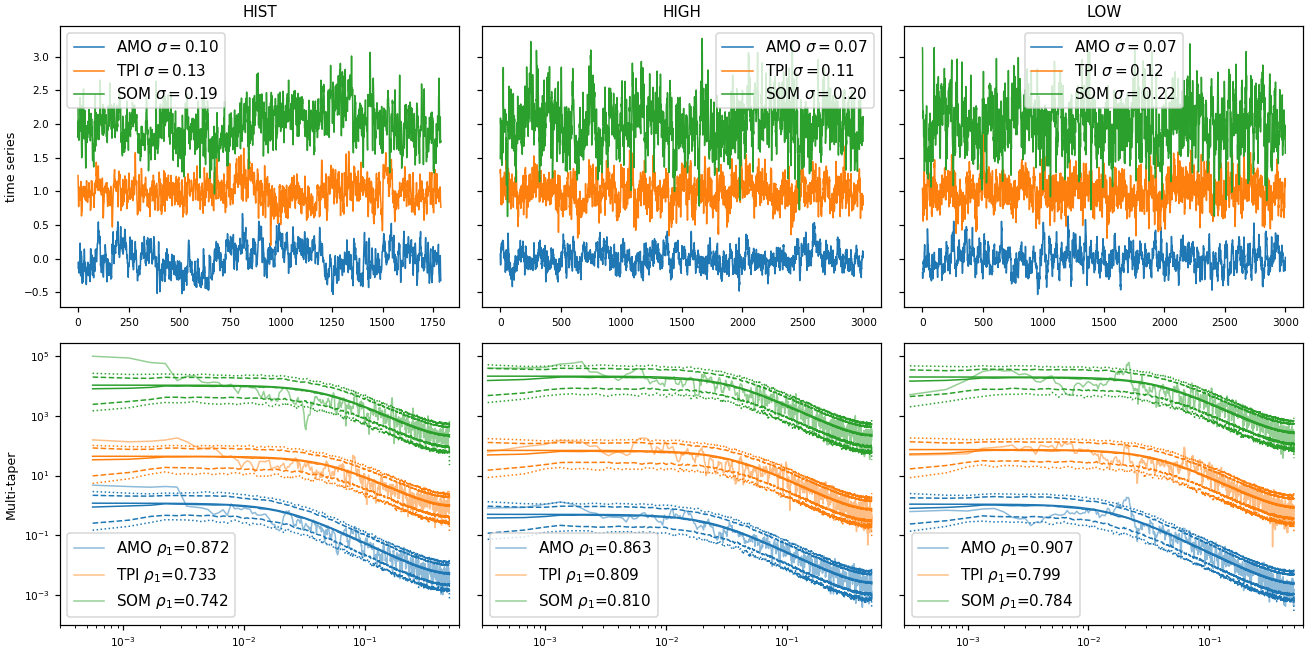

In [50]:
fig, ax = plt.subplots(2,3,figsize=(12,6),constrained_layout=True, sharey='row')
for i, idx in enumerate(['AMO', 'TPI', 'SOM']):
    for j, run in enumerate(['had', 'ctrl', 'lpd']):
        c = f'C{i}'
        key = f'{idx}_{run}'
        AM = tsa.arima_model.ARMA(endog=ds[key].dropna(dim='time').values, order=(1,0)).fit()
        ac, std = AM.arparams[0], np.sqrt(AM.sigma2)
#         std = ds[key].std().values
#         ac = np.corrcoef(ds[key].dropna(dim='time').values[1:], ds[key].dropna(dim='time').shift(time=1).dropna(dim='time').values)[1,0]
        ax[0,j].plot(ds.time, ds[key]+i, label=fr'{idx} $\sigma=${std:.2f}', c=c)
        
        f, Pxx = mtspectrum(ds[key].dropna(dim='time').values)
        ax[1,j].plot(f[1:], Pxx[1:]*10**(2*i), c=c, alpha=.5, label=fr'{idx} $\rho_1$={ac:.3f}')
        ax[1,j].plot(f[1:], AR2_spectrum(sz=std, a1=ac, a2=0, omega=f)[1:]*10**(2*i), c=c)
        
        mc = mc_ar1_spectrum(std=std, phi=ac, n=len(ds[key].dropna(dim='time')), spectrum=mtspectrum)
        ax[1,j].plot(mc[1,1:], mc[0,1:]*10**(2*i), c=c, ls='-')
        ax[1,j].plot(mc[1,1:], mc[2,1:]*10**(2*i), c=c, ls='--')
        ax[1,j].plot(mc[1,1:], mc[3,1:]*10**(2*i), c=c, ls='--')
        ax[1,j].plot(mc[1,1:], mc[4,1:]*10**(2*i), c=c, ls=':')
        ax[1,j].plot(mc[1,1:], mc[5,1:]*10**(2*i), c=c, ls=':')
        

for i in range(3):
    ax[0,i].set_title(['HIST', 'HIGH', 'LOW'][i])
    ax[0,i].legend(fontsize=10)
    ax[1,i].legend(fontsize=10)
#     for j in range(3):
    ax[1,i].set_xlim((3e-4, 6e-1))
    ax[1,i].set_xscale('log', basex=10)
    ax[1,i].set_yscale('log', basey=10)

for i in range(2):  ax[i,0].set_ylabel(['time series', 'Multi-taper'][i])
    
# ax2.fill_between(freq, jackknife[:, 0], jackknife[:, 1], color="red", alpha=0.2)

In [ ]:
ac = .9
print(f'X_t       {0/(1-ac):6.3f}      {1/(1-ac**2):7.4f}')
for n in [10,100,1000,10000,100000,1000000]:
    a = ArmaProcess(np.array([1, -ac]), np.array([1])).generate_sample(nsample=n, burnin=1000)
    
    print(f'{n:7d}:  {np.mean(a):6.3f}      {np.var(a):7.4f}')
    

## testing $\int \hat{S}(f) \, \mathrm{d}f = \mathrm{var}(x(t))$

In [84]:
def int_Sf(f, Pxx):
    df = f[1]-f[0]
    return np.sum(df*Pxx)

print('\033[1midx run   var.  perio Welch MTM   theor  MCper MCmtm    \033[0m')
for i, idx in enumerate(['AMO', 'TPI', 'SOM']):
    for j, run in enumerate(['had', 'ctrl', 'lpd']):
        c = f'C{i}'
        key = f'{idx}_{run}'
#         ac = np.corrcoef(ds[key].dropna(dim='time').values[1:], ds[key].dropna(dim='time').shift(time=1).dropna(dim='time').values)[1,0]
        x = ds[key].dropna(dim='time')
        var = ds[key].var().values
        AM = tsa.arima_model.ARMA(endog=ds[key].dropna(dim='time').values, order=(1,0)).fit()
        ac, std = AM.arparams[0], np.sqrt(AM.sigma2)
        f = np.linspace(0,.5,len(x))
        p = int_Sf(*periodogram(x))
        w = int_Sf(*Welch(x))
        m = int_Sf(*mtspectrum(x))
        t = int_Sf(f, AR2_spectrum(sz=std, a1=ac, a2=0, omega=f))
        c = int_Sf(f, mc_ar1_spectrum(x.values, spectrum=periodogram)['median'])
        d = int_Sf(f, mc_ar1_spectrum(x.values, spectrum=mtspectrum)['median'])
        print(f'{idx} {run:4} {var:.3f}  {p:.3f} {w:.3f} {m:.3f} {t:.3f}  {c:.3f} {d:.3f}    {var/c:7.3f} {var/d:7.3f}    {c/var:7.3f} {d/var:7.3f}')
    print()

idx run   var.  perio Welch MTM   theor MCper MCmtm    
AMO had  0.041  0.041 0.031 0.041 0.041 0.008 0.011     0.996   4.819   3.654     1.004   0.208   0.274
AMO ctrl 0.019  0.019 0.017 0.019 0.019 0.006 0.008     0.999   2.890   2.189     1.001   0.346   0.457
AMO lpd  0.027  0.027 0.025 0.027 0.027 0.009 0.012     0.997   2.853   2.199     1.003   0.351   0.455

TPI had  0.034  0.034 0.032 0.034 0.034 0.007 0.009     0.998   4.822   3.664     1.002   0.207   0.273
TPI ctrl 0.037  0.037 0.035 0.037 0.037 0.013 0.017     0.998   2.875   2.185     1.002   0.348   0.458
TPI lpd  0.041  0.041 0.040 0.041 0.042 0.014 0.019     0.999   2.879   2.195     1.001   0.347   0.456

SOM had  0.079  0.079 0.061 0.079 0.079 0.016 0.022     0.999   4.829   3.656     1.001   0.207   0.273
SOM ctrl 0.112  0.112 0.105 0.112 0.112 0.039 0.051     0.998   2.876   2.184     1.002   0.348   0.458
SOM lpd  0.120  0.120 0.118 0.120 0.121 0.042 0.055     0.993   2.861   2.178     1.007   0.350   0.459



- the equality holds for the periodogram, the Welch method (with some small error), and the multi-taper method
- theoretical and Monte-Carlo median spectra do not work correctly though!

In [ ]:
# theoretical vs. Monte-Carlo
n = 1000
f = np.linspace(0,.5,n)
df = f[1]-f[0]
fig, ax = plt.subplots(3,3, figsize=(8,5), sharey=True, sharex=True, constrained_layout=True)
for i, std in enumerate([0.1,.5,1]):
    for j, ac in enumerate([.1,.5,.9]):
        ax[i,j].plot([0,0],[0,1], c='w', label=fr'var$(X_t) = {std**2/(1-ac**2):.4f}$')

        spec = AR2_spectrum(sz=std, a1=ac, a2=0, omega=f)
        ax[i,j].plot(f, spec, label=fr'theor. $\int S = {np.sum(df*spec):.4f}$')
        
        mc_spec = mc_ar1_spectrum(phi=ac, std=std, n=n, spectrum=periodogram)
        ax[i,j].plot(mc_spec[1,:], mc_spec[0,:], c='C1', label=fr'median  $\int S = {np.sum(df*mc_spec[0,:]):.4f}$')
        ax[i,j].plot(mc_spec[1,:], mc_spec[2,:], c='C1', ls='--')  # 5%
        ax[i,j].plot(mc_spec[1,:], mc_spec[3,:], c='C1', ls='--')  # 95%
        
        
        ax[i,j].set_xscale('log', basex=10)
        ax[i,j].set_yscale('log', basey=10)
        ax[i,j].set_ylim((1e-4, 1e3))
        
        if i==0:  ax[i,j].set_title(fr'$\rho_1=${ac}', fontsize=16)
        if j==0:  ax[i,j].set_ylabel(fr'$\sigma=${std}', fontsize=16)
        ax[i,j].legend(fontsize=8)

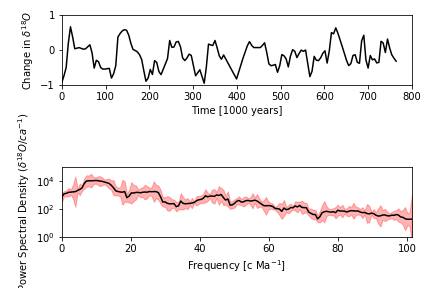

In [4]:
from mtspec import mtspec
from mtspec.util import _load_mtdata

data = _load_mtdata('v22_174_series.dat.gz')

# Calculate the spectral estimation.
spec, freq, jackknife, _, _ = mtspec(
    data=data, delta=4930.0, time_bandwidth=3.5,
    number_of_tapers=5, nfft=312, statistics=True)

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
# Plot in thousands of years.
ax1.plot(np.arange(len(data)) * 4.930, data, color='black')
ax1.set_xlim(0, 800)
ax1.set_ylim(-1.0, 1.0)
ax1.set_xlabel("Time [1000 years]")
ax1.set_ylabel("Change in $\delta^{18}O$")

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_yscale('log')
# Convert frequency to Ma.
freq *= 1E6
ax2.plot(freq, spec, color='black')
ax2.fill_between(freq, jackknife[:, 0], jackknife[:, 1],
                 color="red", alpha=0.3)
ax2.set_xlim(freq[0], freq[-1])
ax2.set_ylim(0.1E1, 1E5)
ax2.set_xlabel("Frequency [c Ma$^{-1}]$")
ax2.set_ylabel("Power Spectral Density ($\delta^{18}O/ca^{-1}$)")

plt.tight_layout()


In [5]:
len(data)

156

In [7]:
len(spec)

157

In [73]:
from pandas.tools.plotting import autocorrelation_plot

/home/dijkbio/.conda/envs/CESM/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.
/home/dijkbio/.conda/envs/CESM/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


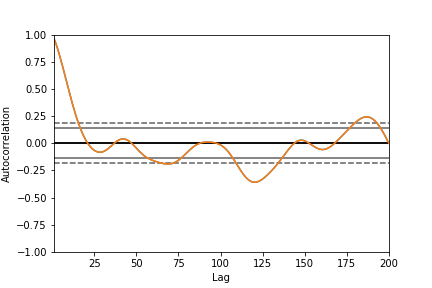

In [75]:
autocorrelation_plot(AMO_ctrl)
autocorrelation_plot(AMO_ctrl)